Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic components as well
Remember to append the new features for the dynamic

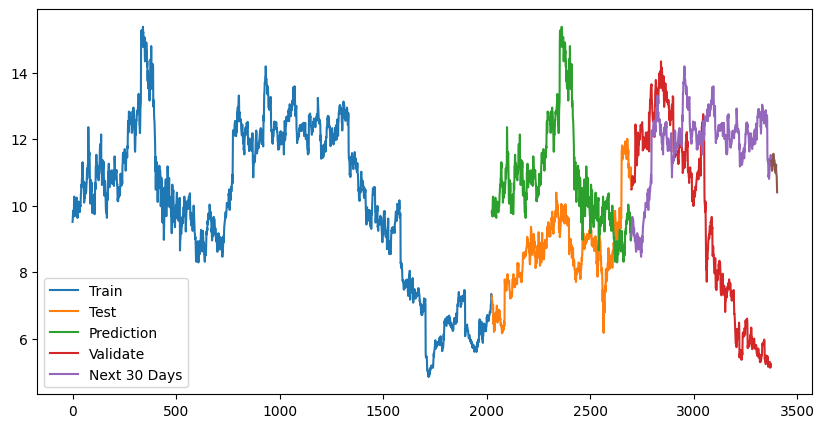

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydlm import dlm, dynamic

# Đọc dữ liệu từ file
df = pd.read_csv('E:/Nam3/HK2/Business_Analyst/github/BDLM/Bayesian_Dynamic_linear_Model/dataset/ERIC.csv')
df = df[['Close']]
df = df.dropna()
df = df.reset_index(drop=True)

# Chia dữ liệu thành tập train, test và validate
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Quá trình Training
y_train = np.array(train_data['Close'])

# Tạo mô hình DLM
myDLM = dlm(y_train)

# Tạo một danh sách các danh sách, trong đó mỗi phần tử là một giá trị của cột 'Close' trong DataFrame
dynamic_features_Close = [[value] for value in df['Close'].values]

# Lấy đúng size theo train_data và thêm mô hình dynamic vào DLM
train_dynamic_Close = dynamic_features_Close[:train_size]
myDLM = myDLM + dynamic(features=train_dynamic_Close, name='dynamicClose', discount=0.99)

# Huấn luyện mô hình DLM
myDLM.fit()

# Quá trình testing
y_test = np.array(test_data['Close'])

# Dự đoán dữ liệu kiểm tra
y_pred = []
for i in range(len(y_test)):
    next_observation = myDLM.predict(date=i+1)
    y_pred.append(next_observation)
    myDLM.append(next_observation)

y_pred = np.array(y_pred)

# Quá trình Validate
y_val = np.array(val_data['Close'])

# Dự đoán dữ liệu validate
y_pred_val = []
for i in range(len(y_val)):
    next_observation = myDLM.predict(date=i+1+len(y_test))
    y_pred_val.append(next_observation)
    myDLM.append(next_observation)

y_pred_val = np.array(y_pred_val)

# Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]
x_next_30_days = np.array(range(last_index+1, last_index+31))

# Dự đoán 30 ngày tiếp theo
y_next_30_days = []
for i in range(30):
    next_observation = myDLM.predict(date=i+1+len(y_test)+len(y_val))
    y_next_30_days.append(next_observation)
    myDLM.append(next_observation)

y_next_30_days = np.array(y_next_30_days)



# Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
mae = np.mean(np.abs(y_pred - y_test))
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('MAE:', mae)
print('MAPE:', mape)

# Vẽ hình
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred[:, 0, 0, 0])
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val[:, 0, 0, 0])
plt.plot(x_next_30_days, y_next_30_days[:, 0, 0, 0])
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next 30 Days'])
plt.show()

